### [Exp-16] Segmentation map으로 도로 이미지 만들기

생성자 판별자 모델중 U-Net 생성자를 이용하여 이미지 생성하기.      

##### 라이브러리 준비.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import data
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

import numpy as np
import random
import pickle

import os
import time
import glob
from PIL import Image
import cv2

from matplotlib import pyplot as plt
from IPython import display

print(np.__version__)
print(tf.__version__)

1.21.4
2.6.0


##### 데이터셋 준비.

In [2]:
base_path = '/aiffel/aiffel/data/cityscapes/'
train_path = os.path.join(base_path, "train/")
train_files = os.path.join(train_path, "*.jpg")
val_path = os.path.join(base_path, "val/")
val_files = os.path.join(val_path, "*.jpg")

train_imgs_path = glob.glob(train_files)
val_imgs_path = glob.glob(val_files)

print(len(train_imgs_path), len(val_imgs_path))

1000 5


In [3]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    label = img[:, :w, :] 
    label = tf.cast(label, tf.float32)
    data = img[:, w:, :] 
    data = tf.cast(data, tf.float32)
    return normalize(data), normalize(label)


In [4]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation1(data1, label1):
    stacked1 = tf.concat([data1, label1], axis=-1)
    
    _pad1 = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded1 = tf.pad(stacked1, _pad1, "REFLECT")
    else:
        padded1 = tf.pad(stacked1, _pad1, "CONSTANT", constant_values=1.)

    out1 = image.random_crop(padded1, size=[256, 256, 6])
    
    out1 = image.random_flip_left_right(out1)
    
    return out1[...,:3], out1[...,3:]

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation2(data2, label2):
    stacked2 = tf.concat([data2, label2], axis=-1)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        stacked2 = image.rot90(stacked2, k=degree)
    
    return stacked2[...,:3], stacked2[...,3:]

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation3(data1, label1):
    stacked1 = tf.concat([data1, label1], axis=-1)
    
    _pad1 = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded1 = tf.pad(stacked1, _pad1, "REFLECT")
    else:
        padded1 = tf.pad(stacked1, _pad1, "CONSTANT", constant_values=1.)

    out1 = image.random_crop(padded1, size=[256, 256, 6])
    
    out1 = image.random_flip_up_down(out1)
    
    return out1[...,:3], out1[...,3:]


div_cnt = 8

augmentation을 통하여 다양한 데이터셋을 구현하기 위해 8000개까지 늘림.   
메모리가 부족하므로, file로 pickle해서 일부분씩 로드하도록 함.  

In [ ]:
def train_datas():
    datas = []
    labels = []
    for img_path in train_imgs_path:
        data, label = load_img(img_path)    
        datas.append(normalize(data))
        labels.append(normalize(label))
        
        data1, label1 = apply_augmentation1(data, label)
        datas.append(normalize(data1))
        labels.append(normalize(label1))
        
        data2, label2 = apply_augmentation2(data, label)
        datas.append(normalize(data2))
        labels.append(normalize(label2))

        data3, label3 = apply_augmentation3(data, label)
        datas.append(normalize(data3))
        labels.append(normalize(label3))
        
        data4, label4 = apply_augmentation1(data, label)
        data4, label4 = apply_augmentation2(data4, label4)
        datas.append(normalize(data4))
        labels.append(normalize(label4))

        data5, label5 = apply_augmentation2(data, label)
        data5, label5 = apply_augmentation3(data5, label5)
        datas.append(normalize(data5))
        labels.append(normalize(label5))

        data6, label6 = apply_augmentation3(data, label)
        data6, label6 = apply_augmentation1(data6, label6)
        datas.append(normalize(data6))
        labels.append(normalize(label6))

        data7, label7 = apply_augmentation1(data, label)
        data7, label7 = apply_augmentation2(data7, label7)
        data7, label7 = apply_augmentation3(data7, label7)
        datas.append(normalize(data7))
        labels.append(normalize(label7))


    return datas, labels


train_X, train_y = train_datas()

rand_dice = np.random.permutation(np.arange(0, len(train_X)))
train_X = [ train_X[i] for i in rand_dice]
train_y = [ train_y[i] for i in rand_dice]

data_cnt = len(train_X)
div_cnt = data_cnt // 1000
block = data_cnt // div_cnt

def save_train_images(i, dx, dy):
    base_path = '/aiffel/aiffel/data/cityscapes/'

    xdata = dx[:block]
    ydata = dy[:block]

    pic_file = os.path.join(base_path, 'datax{}.pic'.format(i))
    with open(pic_file, 'wb') as f:
        pickle.dump(xdata, f)

    pic_file = os.path.join(base_path, 'datay{}.pic'.format(i))
    with open(pic_file, 'wb') as f:
        pickle.dump(ydata, f)
    
    print('saved ', i)


for i in range(div_cnt):            
    save_train_images(i, train_X, train_y)
    
    if i < div_cnt -1:
        train_X = train_X[block:]
        train_y = train_y[block:]


del train_X
del train_y



In [5]:
def get_train_images(i):
    
    base_path = '/aiffel/aiffel/data/cityscapes/'
    pic_file = os.path.join(base_path, 'datax{}.pic'.format(i))
    with open(pic_file, 'rb') as f:
        xdata = pickle.load(f, encoding='bytes')
    
    pic_file = os.path.join(base_path, 'datay{}.pic'.format(i))
    with open(pic_file, 'rb') as f:
        ydata = pickle.load(f, encoding='bytes')
        
    train_images = tf.data.Dataset.from_tensor_slices((xdata, ydata))
    return train_images.shuffle(len(xdata)).batch(100)

##### 인코더와 디코더를 가지는 생성자 U-Net모델 생성.
생성자에 augmentation layer를 넣은 경우 너무 결과가 안좋아 제거함.  

In [7]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.6)(x)
        return self.relu(x)
    

In [8]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [9]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

##### 판별자 생성.  

In [10]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [11]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [12]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [13]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

In [14]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()
sme = losses.MeanSquaredError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

def discriminator_accuracy(real_disc, fake_disc):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_disc, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_disc, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

print("✅")

✅


In [15]:
from tensorflow.keras import optimizers

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    '''
    모델학습 초기에 learning rate를 급격히 높였다가, 
    서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법
    학습 초기에는 learning_rate가 step_num에 비례해서 증가하다가 이후로는 감소
    '''
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

gene_learning_rate = CustomSchedule(d_model=64, warmup_steps=40)
disc_learning_rate = CustomSchedule(d_model=64, warmup_steps=40)
gene_opt = optimizers.Adam(gene_learning_rate, beta_1=.5, beta_2=.999) #2e-4
disc_opt = optimizers.Adam(disc_learning_rate, beta_1=.2, beta_2=.999)

print("✅")

✅


In [16]:
@tf.function
def train_step(data, label):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(data, training=True)
        # Discriminator 예측
        fake_disc = discriminator(data, fake_colored, training=True)
        real_disc = discriminator(data, label, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, label, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
        # Discriminator accuracy
        real_accuracy, fake_accuracy = discriminator_accuracy(real_disc, fake_disc) 
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss, real_accuracy, fake_accuracy

print("✅")

✅


In [17]:
generator = UNetGenerator()
discriminator = Discriminator()

history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[], 'l1_loss':[]}

##### 학습 진행.  

In [18]:
EPOCHS = 10

for epoch in range(1, EPOCHS+1):
    
    for j in range(div_cnt):
        
        # 메모리 낭비를 막기 위해 사용할 데이터만 로드.
        train_imgs = get_train_images(j)
        
        for i, (data, label) in enumerate(train_imgs):
            g_loss, l1_loss, d_loss, real_accuracy, fake_accuracy = train_step(data, label)

            history['gen_loss'].append(g_loss)
            history['disc_loss'].append(d_loss)
            history['l1_loss'].append(l1_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

        # 10회 반복마다 손실을 출력합니다.
        print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                \nGenerator_loss:{g_loss.numpy():.4f} \
                \nL1_loss:{l1_loss.numpy():.4f} \
                \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
        
        # 메모리 낭비를 막기 위해 사용한 데이터 삭제.
        del train_imgs


EPOCH[1] - STEP[10]                 
Generator_loss:3.9683                 
L1_loss:0.1988                 
Discriminator_loss:3.9980

EPOCH[1] - STEP[10]                 
Generator_loss:0.8460                 
L1_loss:0.2560                 
Discriminator_loss:2.1880

EPOCH[1] - STEP[10]                 
Generator_loss:1.9789                 
L1_loss:0.2845                 
Discriminator_loss:1.9200

EPOCH[1] - STEP[10]                 
Generator_loss:0.9617                 
L1_loss:0.5949                 
Discriminator_loss:1.7924

EPOCH[1] - STEP[10]                 
Generator_loss:0.8501                 
L1_loss:0.9107                 
Discriminator_loss:1.6455

EPOCH[1] - STEP[10]                 
Generator_loss:0.6173                 
L1_loss:0.1288                 
Discriminator_loss:1.6836

EPOCH[1] - STEP[10]                 
Generator_loss:0.6905                 
L1_loss:0.2107                 
Discriminator_loss:1.5244

EPOCH[1] - STEP[10]                 
Generator_loss:0.7

##### 학습 결과 확인

In [19]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    # plt.savefig(os.path.join(history_path, 'train_history_{:04d}.png'.format(epoch)))
    plt.show()

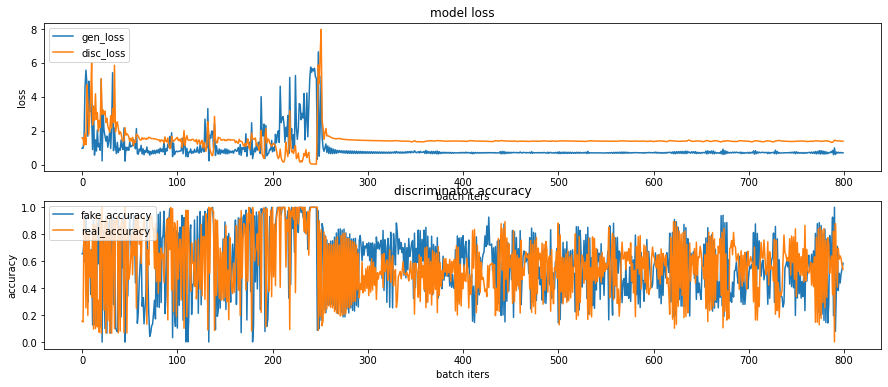

In [20]:
draw_train_history(history)

그래프상의 250정도부터는 loss가 일정한 것을 볼 수 있다. 생성자 로스가 너무 낮아 학습이 진행이 안됨.  
accuracy도 생성자, 판별자 모두 1% 안쪽에서 왔다 갔다함을 볼 수 있었다.  

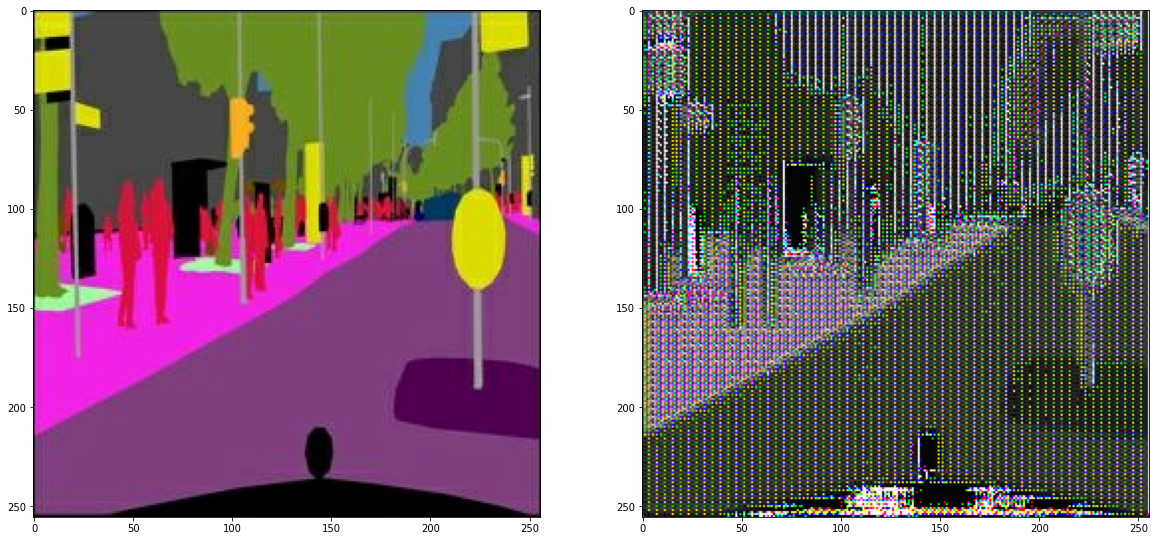

In [22]:
# 입력 이미지 확인.
test_ind = 1

f = train_imgs_path[test_ind]
data, label = load_img(f)

pred = generator(tf.expand_dims(data, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1); plt.imshow(denormalize(data))
plt.subplot(1,2,2); plt.imshow(pred[0])

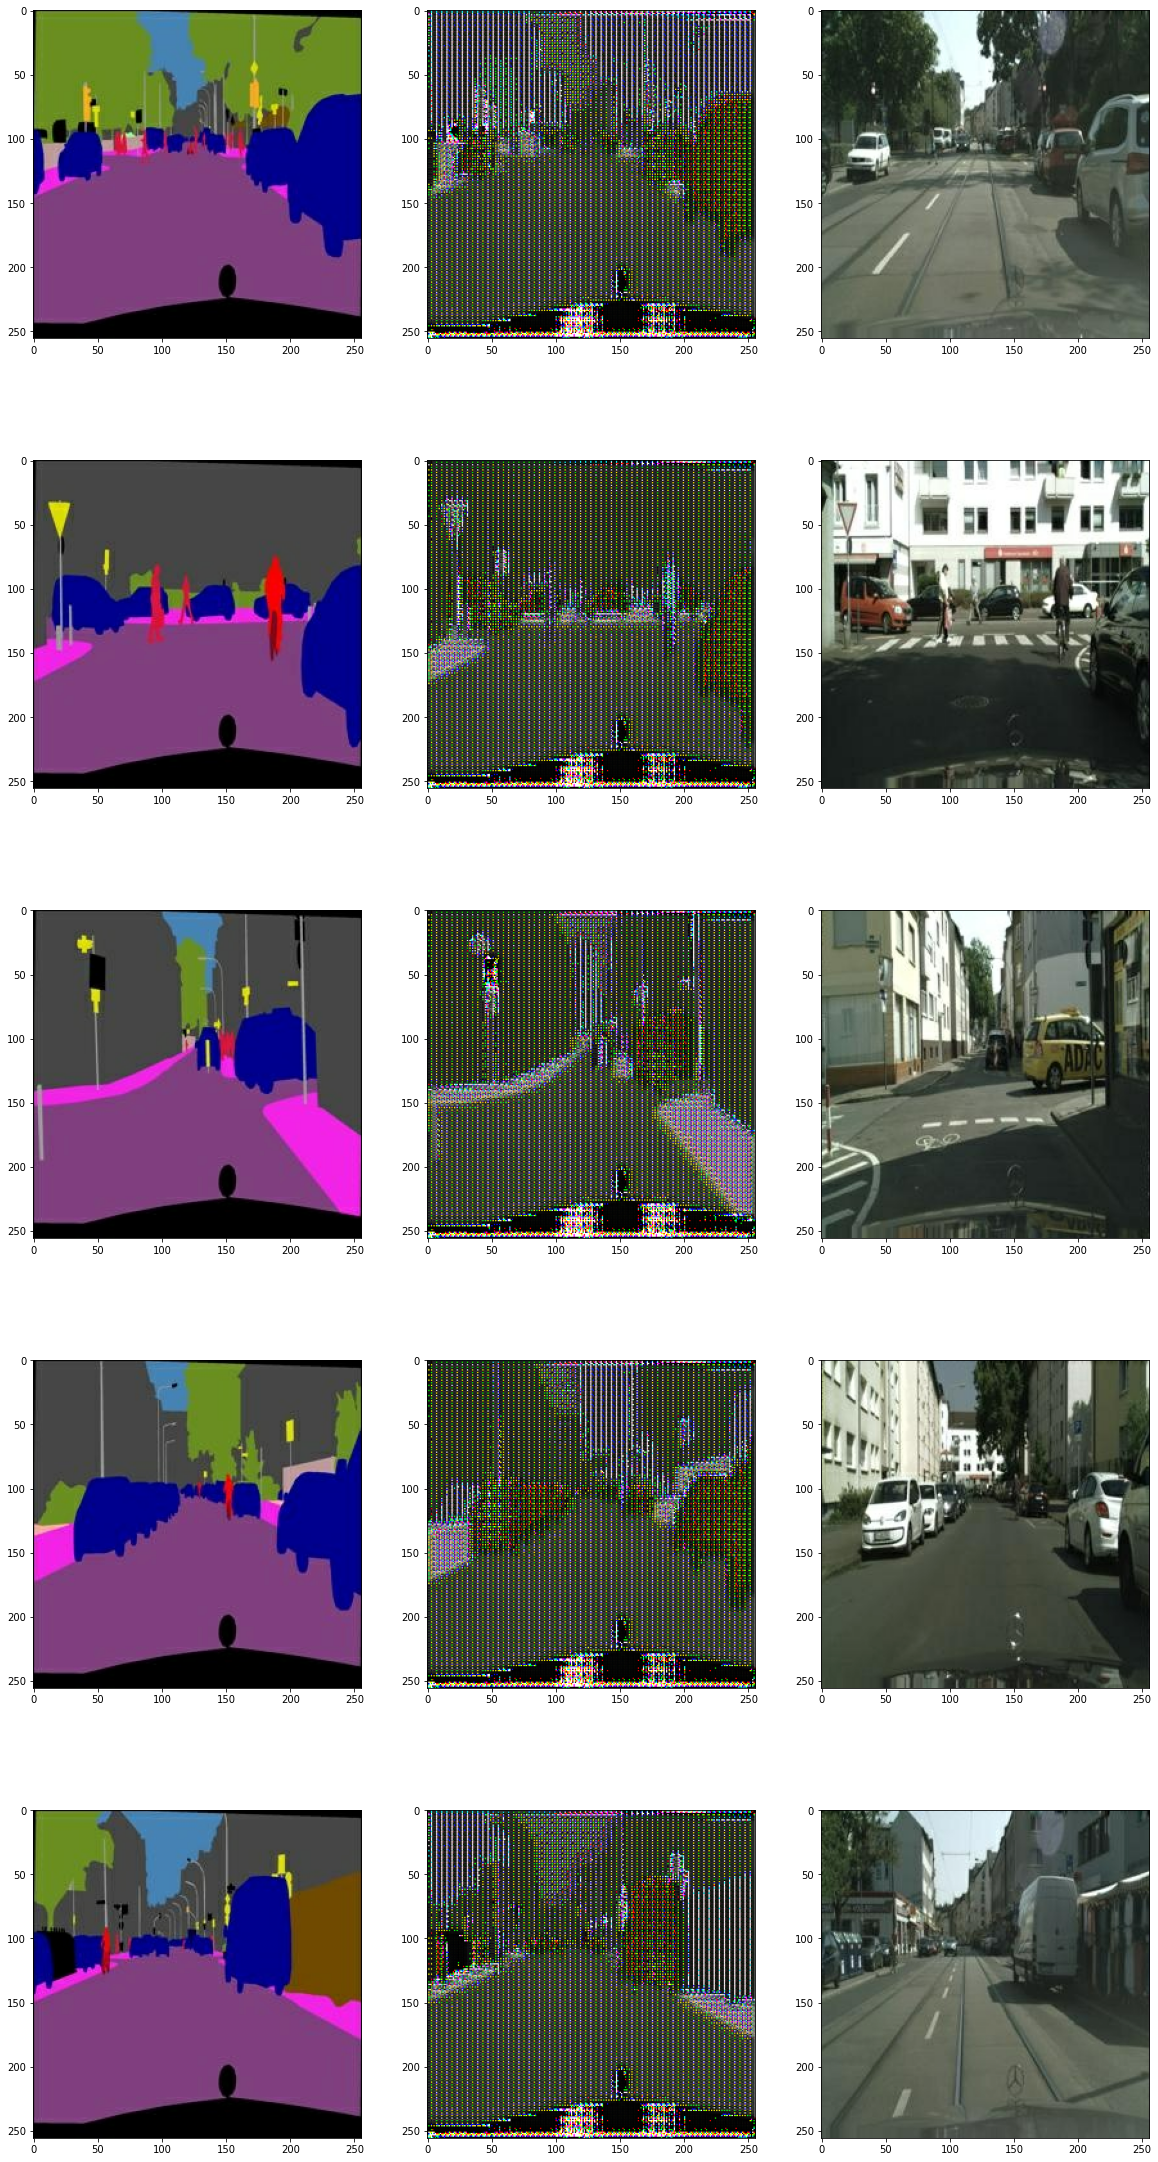

In [24]:
# 검증 이미지 확인

plt.figure(figsize=(20,40))
img_cnt = len(val_imgs_path)
for i in range(img_cnt):
    f = val_imgs_path[i]
    data, label = load_img(f)

    pred = generator(tf.expand_dims(data, 0))
    pred = denormalize(pred)

    plt.subplot(img_cnt,3,i*3 + 1); plt.imshow(denormalize(data))
    plt.subplot(img_cnt,3,i*3 + 2); plt.imshow(pred[0])
    plt.subplot(img_cnt,3,i*3 + 3); plt.imshow(denormalize(label))

##### 회고.  

pix2pix모델중  U-Net generator, discirminator모델을 학습하였다.  
데이터 augmentation은 randomzoom이나, randomTranslation등은 다른 설정 문제일 수 있겠으나 loss가 10을 넘어가버렸다.  
loss가 아래위로 많이 흔들려서 batchSzie를 시스템이 죽지 않는 최대 100으로 설정했다.  
판별자 loss가 거의 0으로 가는 경우가 나타나 너무 빠른 수렴을 하지 않도록 Optimizer의 beta1을 0.2로 낮췄다.  
CustomLearningRate 코드를 붙였는데 초반에 수렴된후 learningRate가 낮아 지도록 설정했는데 올바로되었는지는 모르겠다. 
데이터가 많으면 해결될까 해서 8000개까지 늘리고 메모리 부족 문제를 해결하기 위해 조금씩 로드하여 동작하도록 했다.  
drop 도 0.6으로 올렸으나, 학습을 너무 많이 시켜서 그런지 제너레이터 loss는 좀 낮았지만 이미지가 픽셀처럼 변해버렸다...  
직관은 언제쯤 생길까... 
